In [1]:
# os: Operating System의 줄임말로, 운영체제에서 제공되는 여러 기능을 파이썬에서 사용할 수 있도록 함 (Ex. 디렉토리 경로 이동, 시스템 환경 변수 가져오기 등)
# urllib: URL 작업을 위한 여러 모듈을 모은 패키지. (Ex. urllib.request, urllib.parse, ...)
# cv2: OpenCV 라이브러리로, 실시간 컴퓨터 비전을 목적으로 한 프로그래밍 라이브러리
# numpy(NumPy): 행렬이나 대규모 다차원 배열을 쉽게 처리할 수 있도록 지원하는 라이브러리. 데이터 구조 외에도 수치 계산을 위해 효율적으로 구현된 기능을 제공
# pixellib: 이미지 및 비디오 segmentation을 수행하기 위한 라이브러리. 
# pixellib.semantic: segmentation 기법 중, semantic segmentation을 쉽게 사용할 수 있도록 만든 라이브러리
# matplotlib: 파이썬 프로그래밍 언어 및 수학적 확장 NumPy 라이브러리를 활용한 플로팅 라이브러리로, 데이터 시각화 도구
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

print('슝=3')

슝=3


### 크로마키를 위해 전경으로 독수리 이미지와 배경으로 오로라 이미지를 가져옴

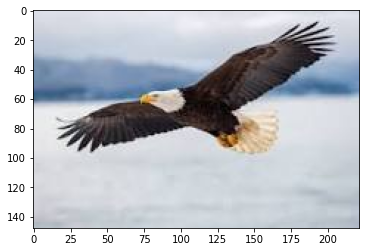

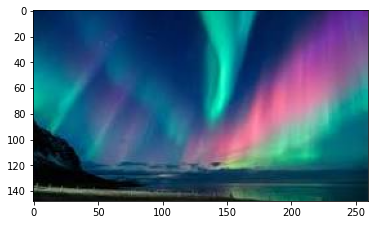

In [2]:
# 준비한 이미지 파일의 경로를 이용하여, 이미지 파일을 읽음
# cv2.imread(경로): 경로에 해당하는 이미지 파일을 읽어서 변수에 저장

# 전경 이미지 가져오기
fore_path = 'foreground_image.jpg'  
fore_orig = cv2.imread(fore_path) 

plt.imshow(cv2.cvtColor(fore_orig, cv2.COLOR_BGR2RGB))
plt.show()



# 백그라운드이미지 가져오기
back_path = 'background_image.jpg'  
back_orig = cv2.imread(back_path) 

plt.imshow(cv2.cvtColor(back_orig, cv2.COLOR_BGR2RGB))
plt.show()

### 이미지에 대한 라벨 훈련을 위해 모델을 가져옴 - DeepLabv3

In [3]:
# 저장할 파일 이름을 결정합니다
# 1. os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. 
# model_dir 에 "/aiffel/human_segmentation/models" 저장
# 2. #os.path.join(a, b)는 경로를 병합하여 새 경로 생성 model_file 에 
# "/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5" 저장
# DeepLab v3+ 모델의 사전 학습된 가중치 파일

# 1
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
# 2
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7b6be1f13be0>)

In [4]:
# PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model = semantic_segmentation()
# pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출
# 사전 학습된 DeepLab v3+ 모델을 로드하는 데 사용되는 함수
model.load_pascalvoc_model(model_file) 

In [5]:
# segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 
# 분할 은 pacalvoc 데이터로 학습된 모델을 이용
# segvalues: 픽셀별 클래스 정보, output: segmentation된 결과 이미지

# 전경 이미지 픽셀별 클래스 정보, output: segmentation된 결과 이미지
segvalues, output = model.segmentAsPascalvoc(fore_path) 

#배경 이미지 픽셀별 클래스 정보, output: segmentation된 결과 이미지
segvalues2, output2 = model.segmentAsPascalvoc(back_path) 

In [6]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

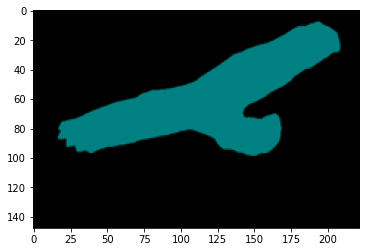

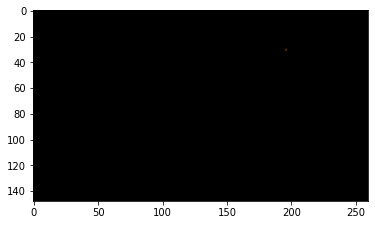

In [7]:
#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()


plt.imshow(output2)
plt.show()

### 알게 된점 - 해당 모델에서는 배경에 대한 라벨링은 없어서 까만 화면으로 나옴 
### 해결책  - 이후단계 부터는 전경에 대한 이미지 처리 
###                최종단계에서 배경 이미지를 합치기로 함

In [9]:
segvalues # segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력


{'class_ids': array([0, 3]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [10]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])
    


background
bird


In [11]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!

#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [12]:
colormap[3] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

array([128, 128,   0])

In [13]:
# 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서
seg_color = (0,128,128) 

(148, 222)


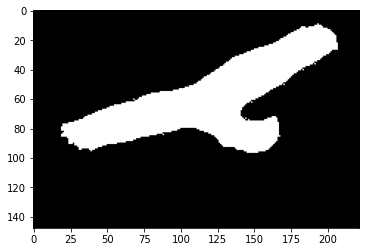

In [14]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray') # True는 흰색(값이 1), False는 검은색(값이 0)
plt.show()

### 세그멘테이션의 결과이미지를 원본이미지과 겹쳐보기

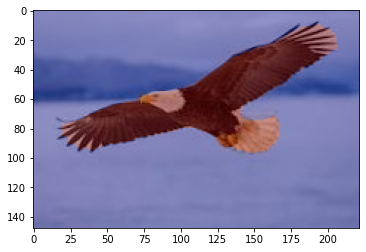

In [15]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
fore_show = fore_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
# seg_map에 사람은 1 흰색, 배경은 0 검정을 255, 0으로 바꾸고 img_mask로 넣어줌
fore_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_fore_mask = cv2.applyColorMap(fore_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
fore_show = cv2.addWeighted(fore_show, 0.6, color_fore_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(fore_show, cv2.COLOR_BGR2RGB))
plt.show()

### 독수리만 전경이미지로 뽑기 위한 과정
#### 1. 배경 흐리게하기 - blur()
#### 1) 전체 이미지 흐리게 하기

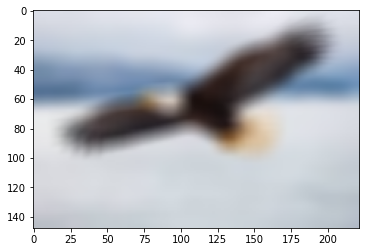

In [17]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
fore_orig_blur = cv2.blur(fore_orig, (13,13))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니

# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.imshow(cv2.cvtColor(fore_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### 2) 흐린 이미지에서 배경만 추출

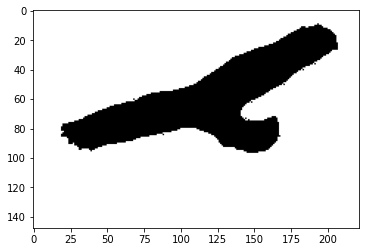

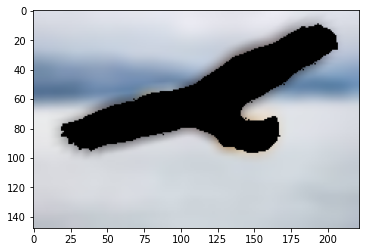

In [18]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
# 사람 흰색, 배경 검정
fore_mask_color = cv2.cvtColor(fore_mask, cv2.COLOR_GRAY2BGR)



# 이미지의 각 픽셀을 반전시킴. 픽셀 값 0은 1로 바뀌고, 픽셀 값 255는 0으로 바뀜
fore_bg_mask = cv2.bitwise_not(fore_mask_color)
plt.imshow(cv2.cvtColor(fore_bg_mask, cv2.COLOR_BGR2RGB))
plt.show()



# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
# 배경 블러 처리된 이미지와 배경 마스크를 AND 연산하여, 배경만 흐리게 처리된 이미지 남김
fore_bg_blur = cv2.bitwise_and(fore_orig_blur, fore_bg_mask)
plt.imshow(cv2.cvtColor(fore_bg_blur, cv2.COLOR_BGR2RGB))

plt.show()

### 독수리만 남긴 이미지 도출

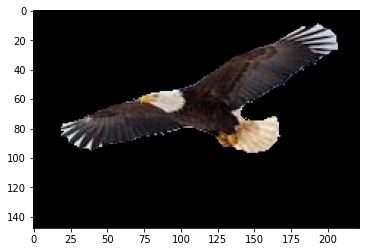

In [24]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크값 255(흰색)와 같으면 원본 이미지 값, 
# 아닌 영역은 블러된 배경 이미지 값 가져오기.
fore_concat = np.where(fore_mask_color==255, fore_orig, fore_bg_blur)
fore_bg_blur = 0
fore_concat = np.where(fore_mask_color==255, fore_orig, fore_bg_blur)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(fore_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 독수리 이미지와 벼경으로 오라라 이미지를 합함

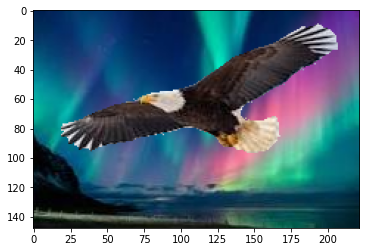

In [28]:
# 배경 이미지를 전경 이미지 크기로 조정
back_orig_resized = cv2.resize(back_orig, (fore_concat.shape[1], fore_concat.shape[0]))

# 독수리와 오로라 배경 합치기
img_concat = np.where(fore_mask_color == 255, fore_concat, back_orig_resized)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 회고: 독수리 이미지만 가져오면서 좀더 정교하게 가져오고 싶었는데, 날개끝 부분 깃털 사이가 탐지되지 못해 아쉽다.
### 추후 이런 부분까지 정교하게 일반화시켜서 추출할수 있는 모델이 있을지 알아보아야겠다.